In [227]:
from importlib import reload
import model_functions
reload(model_functions)
from model_functions import plot_ground_heigth, plot_alpha_scores, fit_model_with_files, load_and_prepare_data, calculate_maneuver_recall
import file_functions
reload(file_functions)
from file_functions import get_filepaths_in_folder_with_ending
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold

# 1. Visualize preprocessed flight data

In [49]:
data_dir = "train_data"
flight_id = '08412468-26ac-4777-9afb-4671f426277b'

parquet_path = os.path.join('..', 'data_process', data_dir, f"{flight_id}.parquet")

df = pd.read_parquet(parquet_path)

#df.info()
print(df.head())

                                                6417134  28827303  45268905  \
TimeStamp                        FrameCounter                                 
2024-02-14 06:46:58.397576+00:00 0             0.457152       0.0       0.0   
2024-02-14 06:46:58.416348+00:00 1             0.457152       0.0       0.0   
2024-02-14 06:47:00.886922+00:00 2             0.457152       0.0       0.0   
2024-02-14 06:47:00.894921+00:00 3             0.457152       0.0       0.0   
2024-02-14 06:47:00.926924+00:00 4             0.457152       0.0       0.0   

                                               108790465  117182271  \
TimeStamp                        FrameCounter                         
2024-02-14 06:46:58.397576+00:00 0                  75.0   2.312171   
2024-02-14 06:46:58.416348+00:00 1                  75.0   2.312171   
2024-02-14 06:47:00.886922+00:00 2                  75.0   2.309550   
2024-02-14 06:47:00.894921+00:00 3                  75.0   2.309550   
2024-02-14 06:47:00.

In [50]:
print(df.columns)
print(df.index)

Index(['6417134', '28827303', '45268905', '108790465', '117182271',
       '156751662', '156875280', '192589766', '203733126', '301190512',
       ...
       '4054750327', '4056189073', '4058842283', '4065458540', '4066202059',
       '4174711423', '4247030081', '4264003232', '4294814812', 'Label'],
      dtype='object', length=141)
MultiIndex([('2024-02-14 06:46:58.397576+00:00',      0),
            ('2024-02-14 06:46:58.416348+00:00',      1),
            ('2024-02-14 06:47:00.886922+00:00',      2),
            ('2024-02-14 06:47:00.894921+00:00',      3),
            ('2024-02-14 06:47:00.926924+00:00',      4),
            ('2024-02-14 06:47:00.946964+00:00',      5),
            ('2024-02-14 06:47:00.950532+00:00',      6),
            ('2024-02-14 06:47:00.961775+00:00',      7),
            ('2024-02-14 06:47:00.978790+00:00',      8),
            ('2024-02-14 06:47:00.984390+00:00',      9),
            ...
            ('2024-02-14 07:03:21.102460+00:00', 253960),
           

<Axes: >

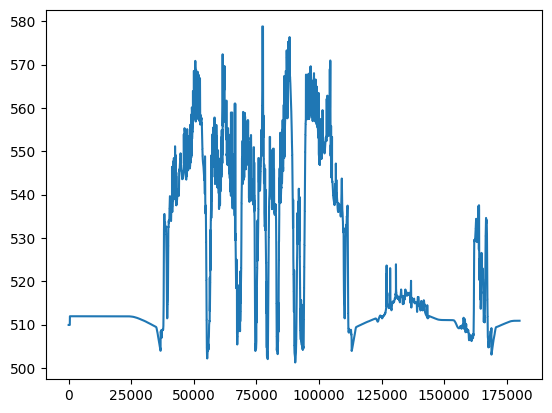

In [ ]:
plot_ground_heigth(df)

# 2. Read Label from preprocessed data

In [92]:
data_dir = "train_data"
flight_id = '0bbf0c4e-fb3c-4213-bff8-ef21ee5ebf79'
data_dir_path = os.path.join('..', 'data_process', data_dir)
parquet_path = os.path.join(data_dir_path, f"{flight_id}.parquet")
df = pd.read_parquet(parquet_path)

label_path = os.path.join(data_dir_path, f"{flight_id}.csv")
labels = pd.read_csv(label_path)
maneuvers = np.unique(labels["maneuver"])

print(maneuvers)
print(df['Label'])


['Climb' 'Descent' 'Hover' 'Left Turn' 'No Maneuver' 'Right Turn'
 'Straight and Level']
TimeStamp                         FrameCounter
2024-02-15 08:12:07.277872+00:00  0               No Maneuver
2024-02-15 08:12:07.289546+00:00  1               No Maneuver
2024-02-15 08:12:09.829034+00:00  2               No Maneuver
2024-02-15 08:12:09.838211+00:00  3               No Maneuver
2024-02-15 08:12:09.867992+00:00  4               No Maneuver
                                                     ...     
2024-02-15 08:28:40.140542+00:00  259788          No Maneuver
2024-02-15 08:28:40.151965+00:00  259789          No Maneuver
2024-02-15 08:28:40.161623+00:00  259790          No Maneuver
2024-02-15 08:28:40.173315+00:00  259791          No Maneuver
2024-02-15 08:28:40.185377+00:00  259792          No Maneuver
Name: Label, Length: 189764, dtype: object


# 3. Time-Series modifications

In [39]:
#TODO Time-Series specific data manipulation required ?

# 4. Lasso model and k-fold cross validation

Fit a linear regression classification lasso model and find the best alpha-parameter with the k-fold cross validation.
The goal of that is to get only the few most significant features, so that we can limit our preprocessing and future models to those columns.

In [161]:
target_file_ending = '.parquet'

model = SGDClassifier(loss='log_loss', penalty='l1', alpha=5) # penalty 'L1' -> Lasso

test_file_paths = get_filepaths_in_folder_with_ending('test_data', target_file_ending)
validate_file_paths = get_filepaths_in_folder_with_ending('validate_data', target_file_ending)
train_file_paths = get_filepaths_in_folder_with_ending('train_data', target_file_ending)
model_train_file_paths = np.concatenate((validate_file_paths, train_file_paths))

In [162]:
possible_maneuvers = set()
test_maneuver_file_paths = get_filepaths_in_folder_with_ending('test_data', '.csv')
validate_maneuver_file_paths = get_filepaths_in_folder_with_ending('validate_data', '.csv')
train_maneuver_file_paths = get_filepaths_in_folder_with_ending('train_data', '.csv')
maneuver_file_paths = np.concatenate((test_maneuver_file_paths, validate_maneuver_file_paths, train_maneuver_file_paths))

for file in maneuver_file_paths:
    labels = pd.read_csv(file)
    possible_maneuvers.update(map(str.lower, np.unique(labels["maneuver"])))

print(possible_maneuvers)
possible_maneuvers = list(possible_maneuvers)

columns = fit_model_with_files(model, model_train_file_paths, possible_maneuvers)

{'hover', 'autorotation', 'left turn', 'climb', 'right turn', 'no maneuver', 'descent', 'straight and level'}
..\data_process\validate_data\a366ff0e-ac1e-4632-821f-594ee8750b90.parquet
(428452, 189)
..\data_process\validate_data\b5a540db-434b-4c3d-86dd-4668d40586c2.parquet
(398503, 189)
..\data_process\validate_data\ef4852a4-fcfe-429b-b753-d11e2ad08cac.parquet
(439352, 189)
..\data_process\train_data\08412468-26ac-4777-9afb-4671f426277b.parquet
(180148, 189)
..\data_process\train_data\0bbf0c4e-fb3c-4213-bff8-ef21ee5ebf79.parquet
(189764, 189)
..\data_process\train_data\1675a16e-a2a3-4038-9007-50b0b26a685c.parquet
(217385, 189)
..\data_process\train_data\21194a58-8a4d-4d0f-a4a9-e374393183b4.parquet
(398883, 189)
..\data_process\train_data\28bd3cd3-1d6a-403f-ab8a-83efaf260dd0.parquet
(291774, 189)
..\data_process\train_data\2a2467dd-9cb2-45de-a64f-f182395b3d1a.parquet
(205635, 189)
..\data_process\train_data\39b2c145-c49f-470b-8280-d253fa98153f.parquet
(331620, 189)
..\data_process\train

In [164]:
coefficients = pd.DataFrame(model.coef_, columns=columns)

# identify unnecessary features (zero coefficients across all classes)
unnecessary_features = coefficients.columns[(coefficients == 0).all()].tolist()
print(len(unnecessary_features))

necessary_features = coefficients.columns[(coefficients != 0).any()].tolist()
print(len(necessary_features))
print(necessary_features)

150
39
['108790465', '203733126', '301190512', '353872548', '419755350', '513685691', '610037603', '614270119', '637219977', '760531114', '943710121', '1049691088', '1105598667', '1112206407', '1308053202', '1464341275', '1515452476', '1637431807', '1847367549', '1909389254', '2142867155', '2275361864', '2298125514', '2400822283', '2546226082', '2690567179', '2716830861', '2979223644', '3063191758', '3590140009', '3742756340', '3771464240', '3871827618', '3981973171', '4021288050', '4054750327', '4056189073', '4174711423', '4294814812']


Alpha: 0.05, Score: 0.3570438807103296
Alpha: 0.1, Score: 0.2668056476278629
Alpha: 1, Score: 0.17321889133886043
Alpha: 3, Score: 0.4287130508280571
Alpha: 5, Score: 0.5281417121342904
Alpha: 7, Score: 0.5326845515231818
Alpha: 10, Score: 0.4385906879489242
Alpha: 20, Score: 0.5187729954685367
Alpha: 50, Score: 0.41480690797303377
Alpha: 100, Score: 0.2668098494235176
Alpha: 200, Score: 0.4294300044811299
Alpha: 500, Score: 0.4141463579920095
Alpha: 1000, Score: 0.4165317416519968
Best Alpha: 7, Best CV Score: 0.5326845515231818


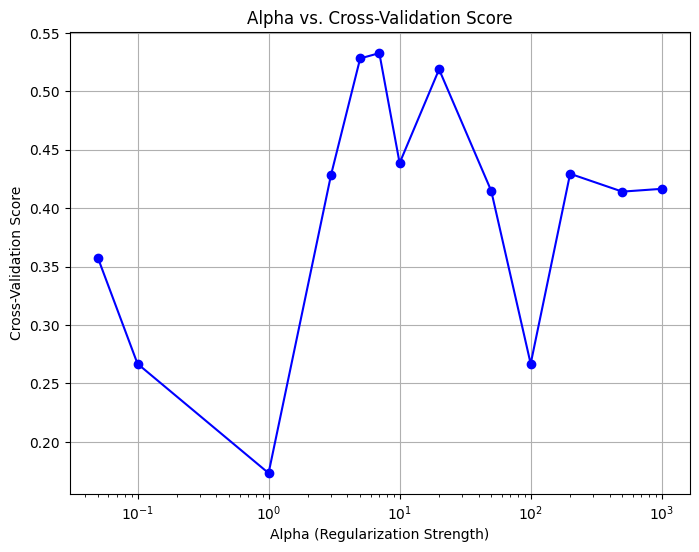

In [165]:
alphas = [0.05, 0.1, 1, 3, 5, 7, 10, 20, 50, 100, 200, 500, 1000]
kf = KFold(n_splits=4, shuffle=True)

best_alpha = None
best_score = -np.inf

alpha_scores = []
for alpha in alphas:
    scores = []

    for train_idx, val_idx in kf.split(model_train_file_paths):
        model = SGDClassifier(loss='log_loss', penalty='l1', alpha=alpha) # penalty 'L1' -> Lasso

        first_file = True
        # Train Split
        columns = fit_model_with_files(model, model_train_file_paths[[idx]], possible_maneuvers)
    
        # Validation Split
        val_scores = []
        for idx in val_idx:
            X, y = load_and_prepare_data(model_train_file_paths[idx])   
            val_scores.append(model.score(X, y))

        scores.append(np.mean(val_scores))
    
    mean_score = np.mean(scores)
    alpha_scores.append((alpha, mean_score))
    print(f"Alpha: {alpha}, Score: {mean_score}")
    
    # Update the best alpha if needed
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

print(f"Best Alpha: {best_alpha}, Best CV Score: {best_score}")
plot_alpha_scores(alpha_scores) # adjust alphas according to plot

In [166]:
final_model = SGDClassifier(loss='log_loss', penalty='l1', alpha=best_alpha)

columns = fit_model_with_files(final_model, model_train_file_paths, possible_maneuvers)

In [168]:
coefficients = pd.DataFrame(final_model.coef_, columns=columns)

# identify unnecessary features (zero coefficients across all classes)
unnecessary_features = coefficients.columns[(coefficients == 0).all()].tolist()
print(f"Unnecessary: {len(unnecessary_features)}")

necessary_features = coefficients.columns[(coefficients != 0).any()].tolist()
print(f"Necessary: {len(necessary_features)}")
print(necessary_features)

Unnecessary: 154
Necessary: 35
['108790465', '203733126', '301190512', '353872548', '419755350', '513685691', '610037603', '637219977', '760531114', '1105598667', '1112206407', '1464341275', '1515452476', '1637431807', '1847367549', '1909389254', '2142867155', '2275361864', '2298125514', '2400822283', '2546226082', '2690567179', '2716830861', '2979223644', '3063191758', '3590140009', '3742756340', '3771464240', '3871827618', '3981973171', '4021288050', '4054750327', '4056189073', '4174711423', '4294814812']


In [ ]:
# after running the lasso model, only following columns are relevant:
#

In [ ]:
# TEST
maneuver_recalls = list()
maneuver_scores = list()

for test_file in test_file_paths:
    X, _ = load_and_prepare_data(test_file)
    preds = final_model.predict(X)
    flight_id = os.path.splitext(os.path.basename(test_file))[0]
    dir_path = os.path.dirname(test_file)

    maneuver_score, maneuver_recall = calculate_maneuver_recall(dir_path, flight_id, X, preds)
    print(maneuver_score)
    print(maneuver_recall)
    maneuver_scores.append(maneuver_score)
    maneuver_recalls.append(maneuver_recall)

{'autorotation': 0.0, 'descent': 0.0, 'no maneuver': 0.45454545454545453, 'right turn': 0.0, 'climb': 0.0, 'hover': 0.0, 'left turn': 0.0}
0.45454545454545453
{'autorotation': 0.0, 'climb': 0.0, 'descent': 0.0, 'hover': 0.0, 'left turn': 0.0, 'no maneuver': 0.48148148148148145, 'right turn': 0.0, 'straight and level': 0.0}
0.48148148148148145
{'climb': 0.0, 'descent': 0.0, 'hover': 0.0, 'left turn': 0.0, 'no maneuver': 0.4782608695652174, 'right turn': 0.0, 'straight and level': 0.0}
0.4782608695652174
